based on https://jhat.readthedocs.io/en/latest/examples/plot_b_nircam.html

In [1]:
%matplotlib inline


# JWST NIRCAM

Aligning JWST/NIRCAM images with JHAT.


An example NIRCam Dataset is downloaded, and then a series of
alignment methods are used. For more information on the
key parameters used for alignment see 
`params:Useful Parameters`.

In [2]:
import sys,os,glob
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.visualization import (simple_norm,LinearStretch)
from astroquery.gaia import Gaia

from scipy.ndimage import binary_dilation

import jhat
from jhat import jwst_photclass,st_wcs_align

from nbutils import xmatch_common



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


## Relative Alignment

**Download some Data**

For this example we download 2 JWST NIRCam images from MAST. They're
the same field but different filters. Note that 
the code will also work for level 3 data images.



In [4]:
obs_table1 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f200w')
data_products_by_obs = Observations.get_product_list(obs_table1)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcb1']

In [18]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617603           JWST            image ...     PUBLIC           2   F200W

In [19]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                         Local Path                                          ...
                                           str92                                             ...
-------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcb1/jw02107041001_02101_00001_nrcb1_cal.fits ...

In [20]:
obs_table2 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f360m')
data_products_by_obs = Observations.get_product_list(obs_table2)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcblong']

In [21]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617252           JWST            image ...     PUBLIC           2   F360M

In [22]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                            Local Path                                             ...
                                              str98                                                ...
-------------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcblong/jw02107041001_02101_00001_nrcblong_cal.fits ...

**Create a Photometric Catalog for Relative Alignment**

We choose one of the images to be the reference image, and then 
create a catalog that we will use to align the other image.



In [60]:
ref_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.fits')[0]

In [61]:
jwst_phot = jwst_photclass()
jwst_phot.run_phot(imagename=ref_image,photfilename='auto',overwrite=True,ee_radius=80,use_dq=True)
ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

0 jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.phot.txt


2024-09-26 13:44:08,148 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-26 13:44:08,475 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-26 13:44:08,495 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-26 13:44:08,498 - stpipe - INFO - Instrument: NIRCAM
2024-09-26 13:44:08,499 - stpipe - INFO - Detector: NRCA4
2024-09-26 13:44:08,499 - stpipe - INFO - Filter: F090W
2024-09-26 13:44:08,500 - stpipe - INFO - Pupil: CLEAR
2024-09-26 13:44:08,502 - stpipe - INFO - Subarray: FULL
2024-09-26 13:44:08,551 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.36200000000000004
aper_sum_7.5px annulus_median_7.5px aper_bkg_7.5px ...   x_idl      y_idl   
-------------- -------------------- -------------- ... ---------- ----------
    217.391903              0.74648     131.211238 ... -26.505511 -31.343517
     161.09213             0.895343     157.377412 ...  -4.488737 -31.511663
   1348.122958             1.945721     342.005957 ...  10.300244 -31.600683
    434.170569             2.055243     361.257068 ...  11.095951 -31.573687
   2133.167646             4.606422     809.686251 ...  14.891911 -31.506553
    1683.51849             3.081981     541.730124 ...  20.102072 -31.548196
   1268.387746             4.799665     843.653313 ...  21.394131  -31.62952
    498.478451             2.399218     421.718556 ...  22.170991  -31.55809
   1791.849782               5.4892     964.855184 ...  28.871605 -31.576615
   1149.240204             1.090143     191.618141 ...   -28.9046 -31.336692
           ...                  ...            ... 

**Align the second image**

The plots outputted here show the various steps used by jhat to
determine the true matching sources in the image, and the
subsequent correction needed for optimal alignment.



In [63]:
# align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.fits')[0]
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_cal.fits')[0]

0 ./jwstred_temp_gaia/jw01334001001_04101_00001_nrca4.phot.txt
Using DQ extension!!


2024-09-26 13:46:45,446 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-26 13:46:45,806 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-26 13:46:45,821 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-26 13:46:45,823 - stpipe - INFO - Instrument: NIRCAM
2024-09-26 13:46:45,824 - stpipe - INFO - Detector: NRCA4
2024-09-26 13:46:45,825 - stpipe - INFO - Filter: F150W
2024-09-26 13:46:45,826 - stpipe - INFO - Pupil: CLEAR
2024-09-26 13:46:45,827 - stpipe - INFO - Subarray: FULL
2024-09-26 13:46:45,868 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.2172
dmag 0.1
sharpness 0.9
roundness1 0.7
mag 21
x 2008
y 2008
reffile_d2d 0.15
*** Note: close plot to continue!


<IPython.core.display.Javascript object>


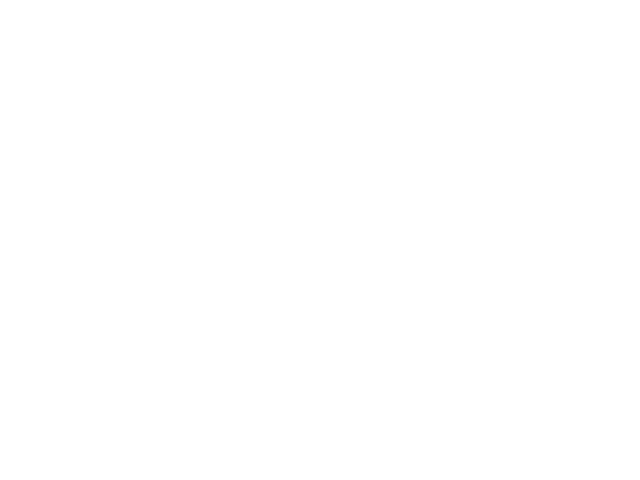

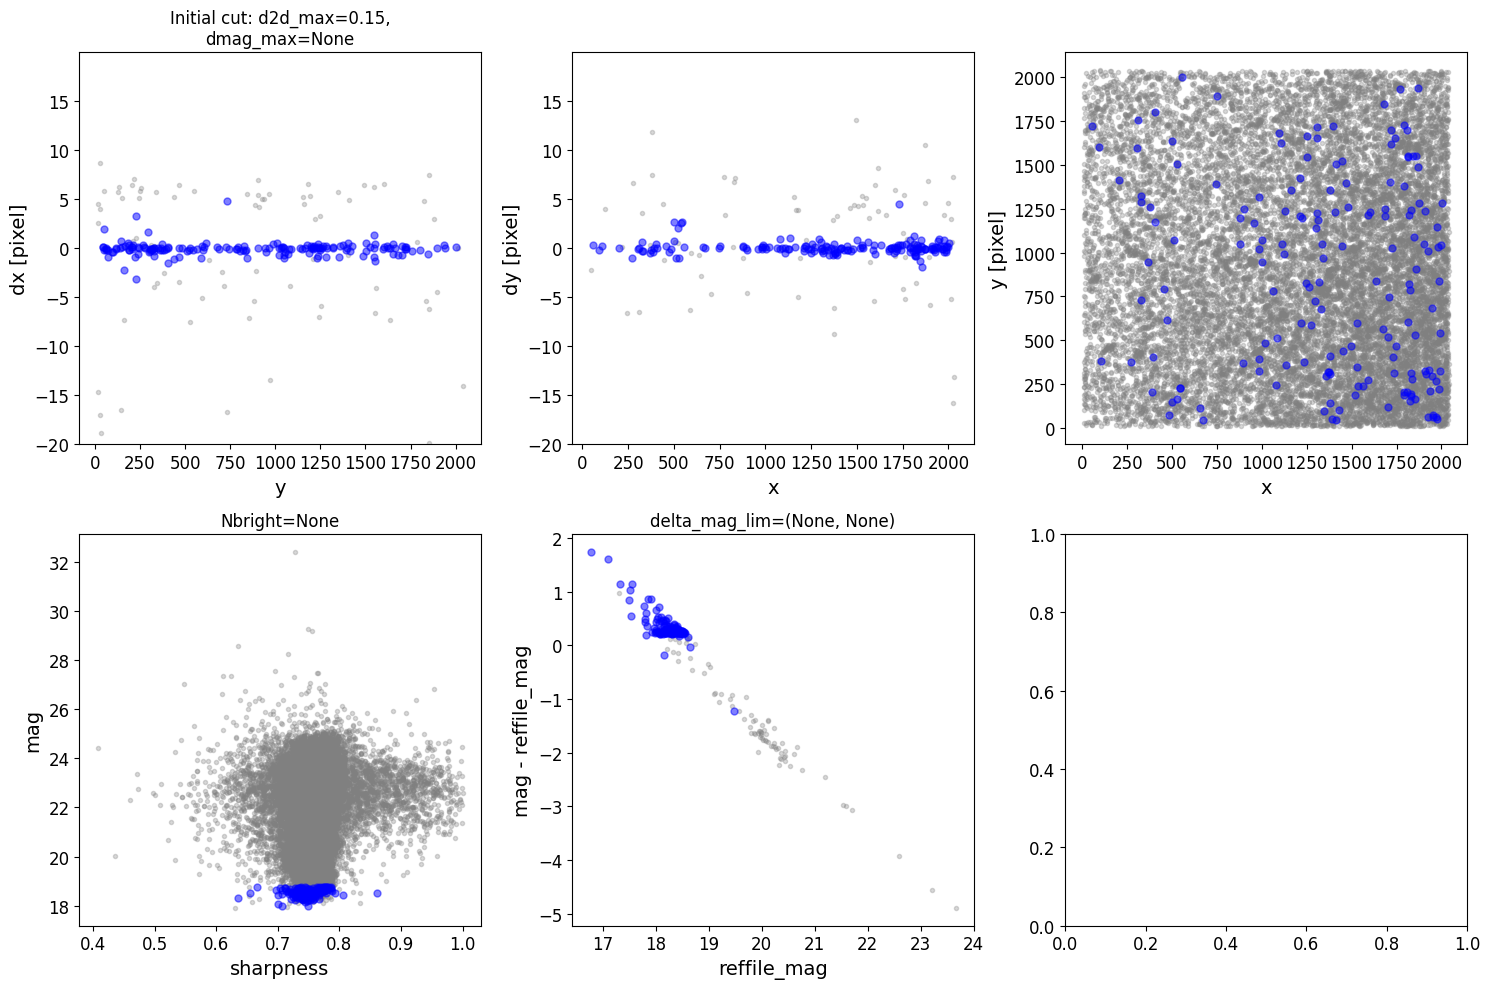

   slope  intercept  maxval  index  d_bestguess  fwhm  multimax
0.000391       -0.4   114.0      4    -0.050005   1.6     False
d_rot_tmp 0.7499946592293825
Keeping 145 out of 145, skippin 0 because of null values in columns d_rot_tmp
median: 0.036844
75.000000 percentile cut: max residual for cut: 0.355323
__tmp_residuals 0.3553232443509177
median: 0.054773
i:00 mean:0.054773(0.016732) stdev:0.173073(0.011776) X2norm:1.00 Nchanged:0 Ngood:108 Nclip:37

mean: 0.059996
i:01 mean:0.059996(0.020174) stdev:0.227352(0.014209) X2norm:1.00 Nchanged:20 Ngood:128 Nclip:17

mean: 0.059804
i:02 mean:0.059804(0.023153) stdev:0.270997(0.016312) X2norm:1.00 Nchanged:10 Ngood:138 Nclip:7

mean: 0.033925
i:03 mean:0.033925(0.025106) stdev:0.299173(0.017690) X2norm:1.00 Nchanged:5 Ngood:143 Nclip:2

mean: 0.022014
i:04 mean:0.022014(0.026151) stdev:0.313809(0.018427) X2norm:1.00 Nchanged:2 Ngood:145 Nclip:0

mean: 0.022014
i:05 mean:0.022014(0.026151) stdev:0.313809(0.018427) X2norm:1.00 Nchanged:0 Ngo

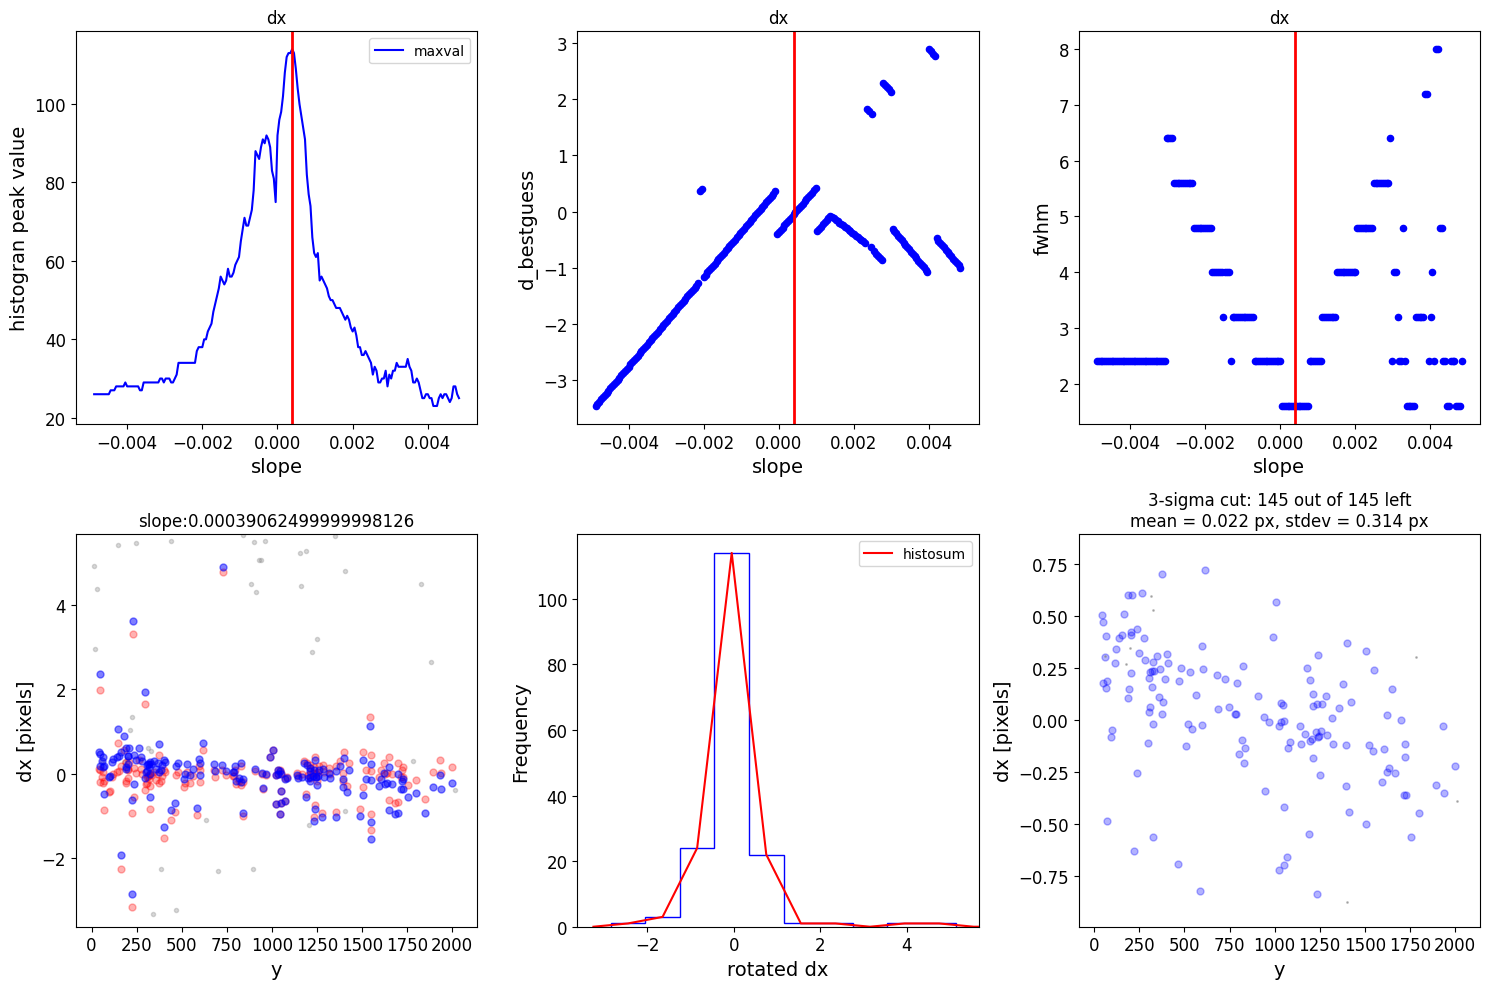

   slope  intercept  maxval  index  d_bestguess  fwhm  multimax
0.000146      -0.15   108.0      3    -0.042939   1.6     False
d_rot_tmp 0.7570610854132138
Keeping 136 out of 136, skippin 0 because of null values in columns d_rot_tmp
median: -0.095475
75.000000 percentile cut: max residual for cut: 0.333248
__tmp_residuals 0.33324760028206873
median: -0.090191
i:00 mean:-0.090191(0.016574) stdev:0.166570(0.011662) X2norm:1.00 Nchanged:0 Ngood:102 Nclip:34

mean: -0.105766
i:01 mean:-0.105766(0.020097) stdev:0.216452(0.014150) X2norm:1.00 Nchanged:15 Ngood:117 Nclip:19

mean: -0.117870
i:02 mean:-0.117870(0.022280) stdev:0.247093(0.015690) X2norm:1.00 Nchanged:7 Ngood:124 Nclip:12

mean: -0.123037
i:03 mean:-0.123037(0.024448) stdev:0.276594(0.017220) X2norm:1.00 Nchanged:5 Ngood:129 Nclip:7

mean: -0.093046
i:04 mean:-0.093046(0.027009) stdev:0.311478(0.019027) X2norm:1.00 Nchanged:5 Ngood:134 Nclip:2

mean: -0.080758
i:05 mean:-0.080758(0.027991) stdev:0.325228(0.019720) X2norm:1.00 

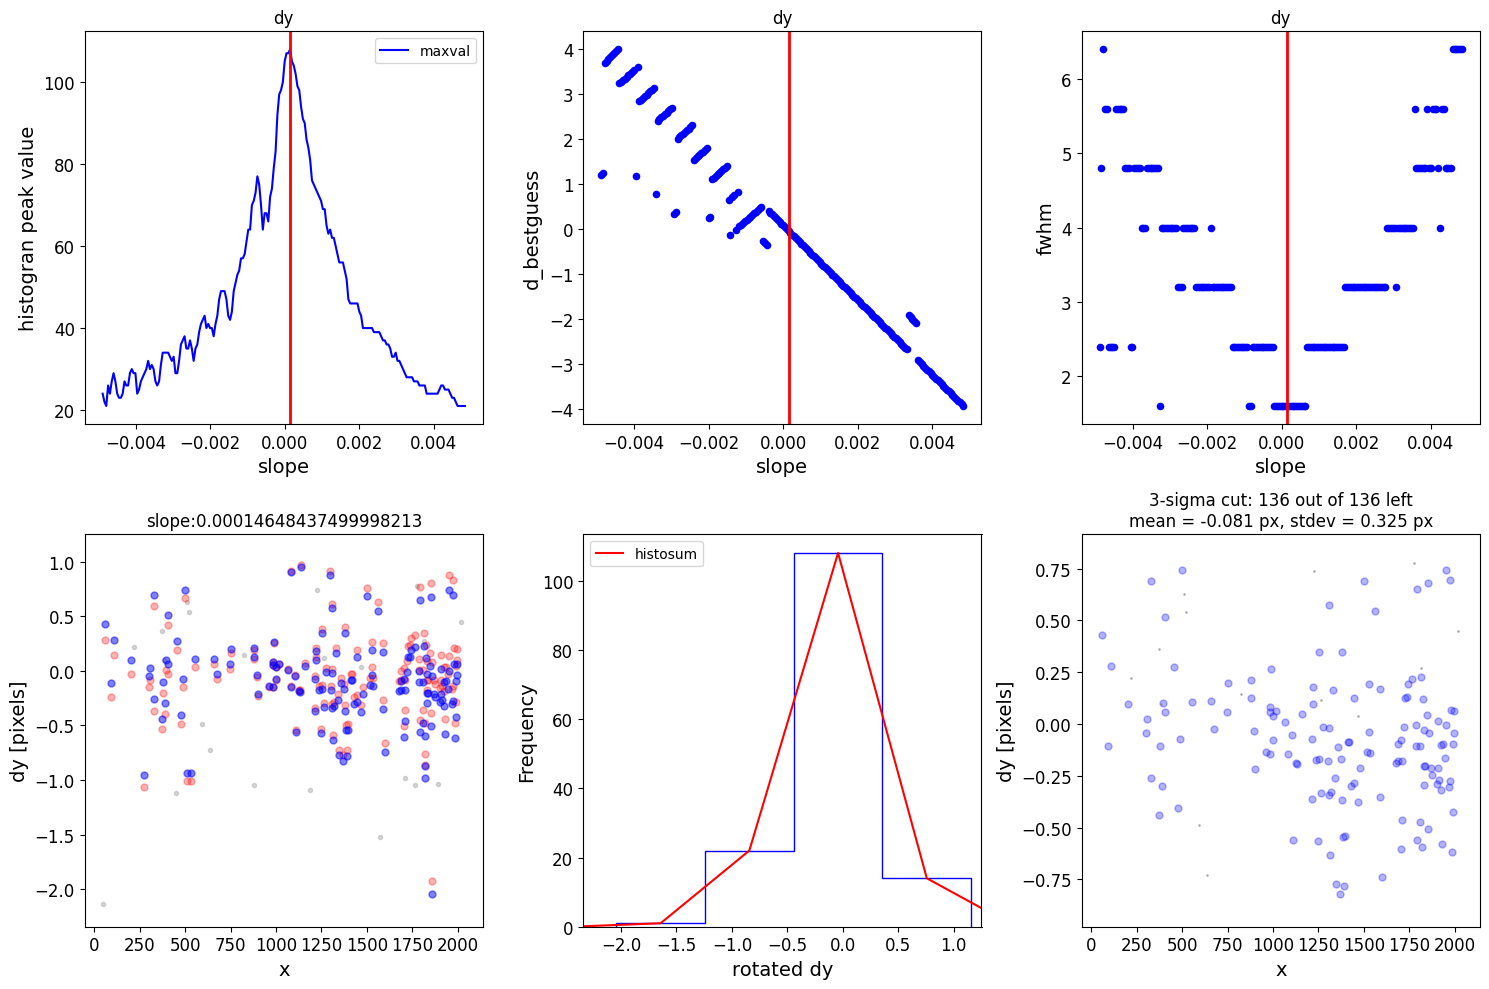

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-09-26 13:47:13,766 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-09-26 13:47:14,513 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01334001001_04101_00001_nrca4_cal.fits>],).
2024-09-26 13:47:14,519 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_jhat.fits
  output_dir: ./jwstred_temp_gaia
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_

replacing SIP ./jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_jhat.fits


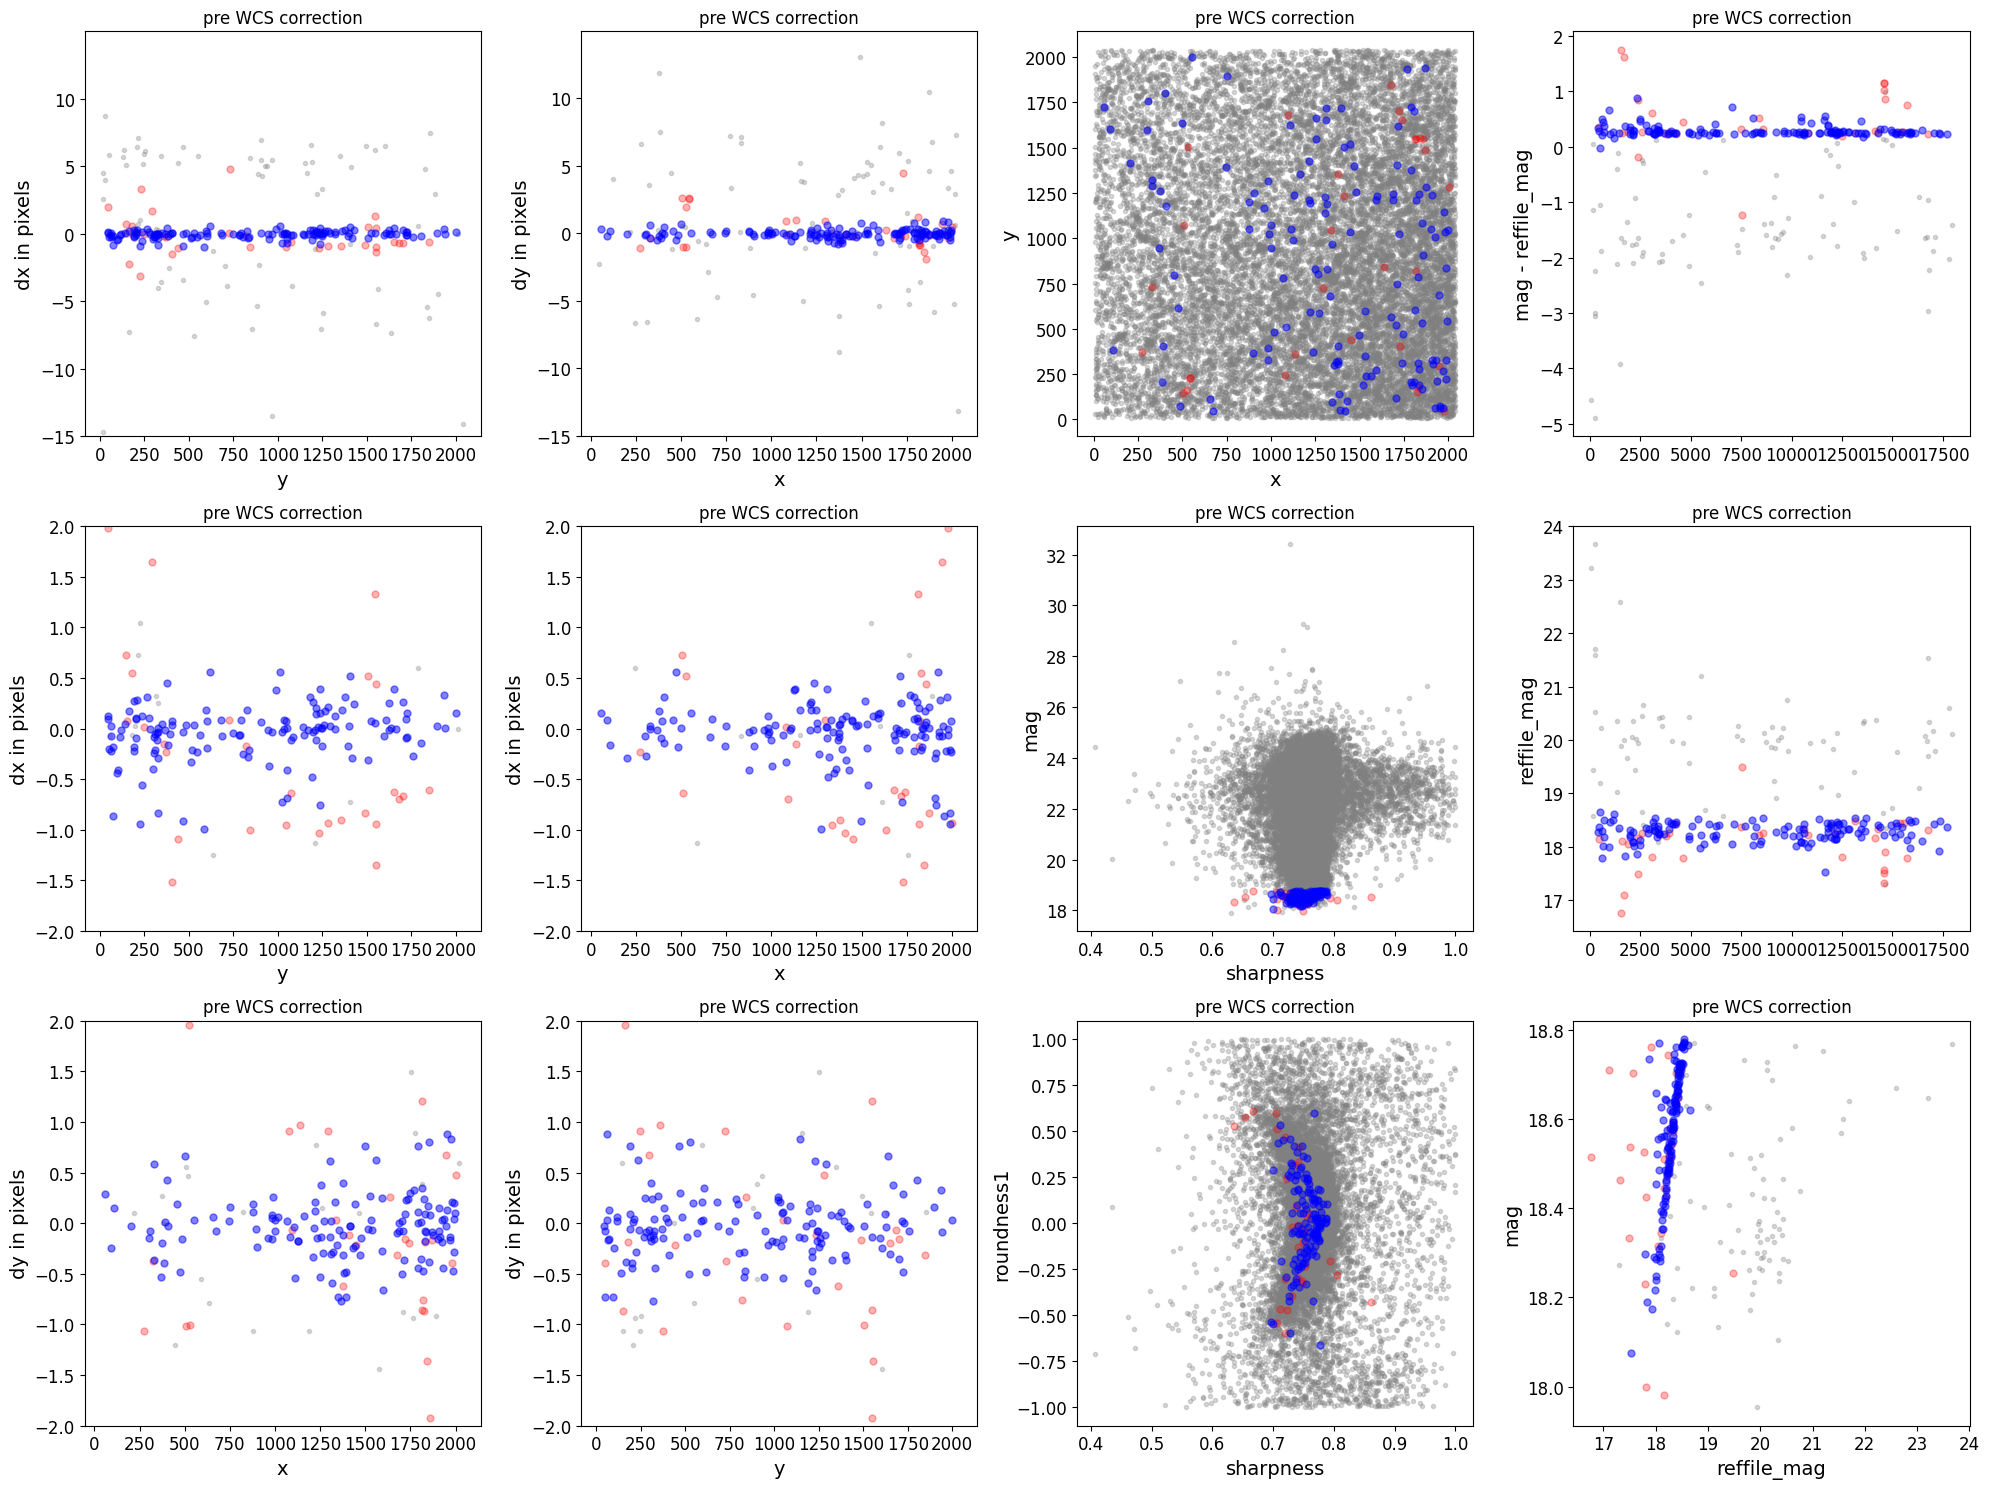

./jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_jhat.fits


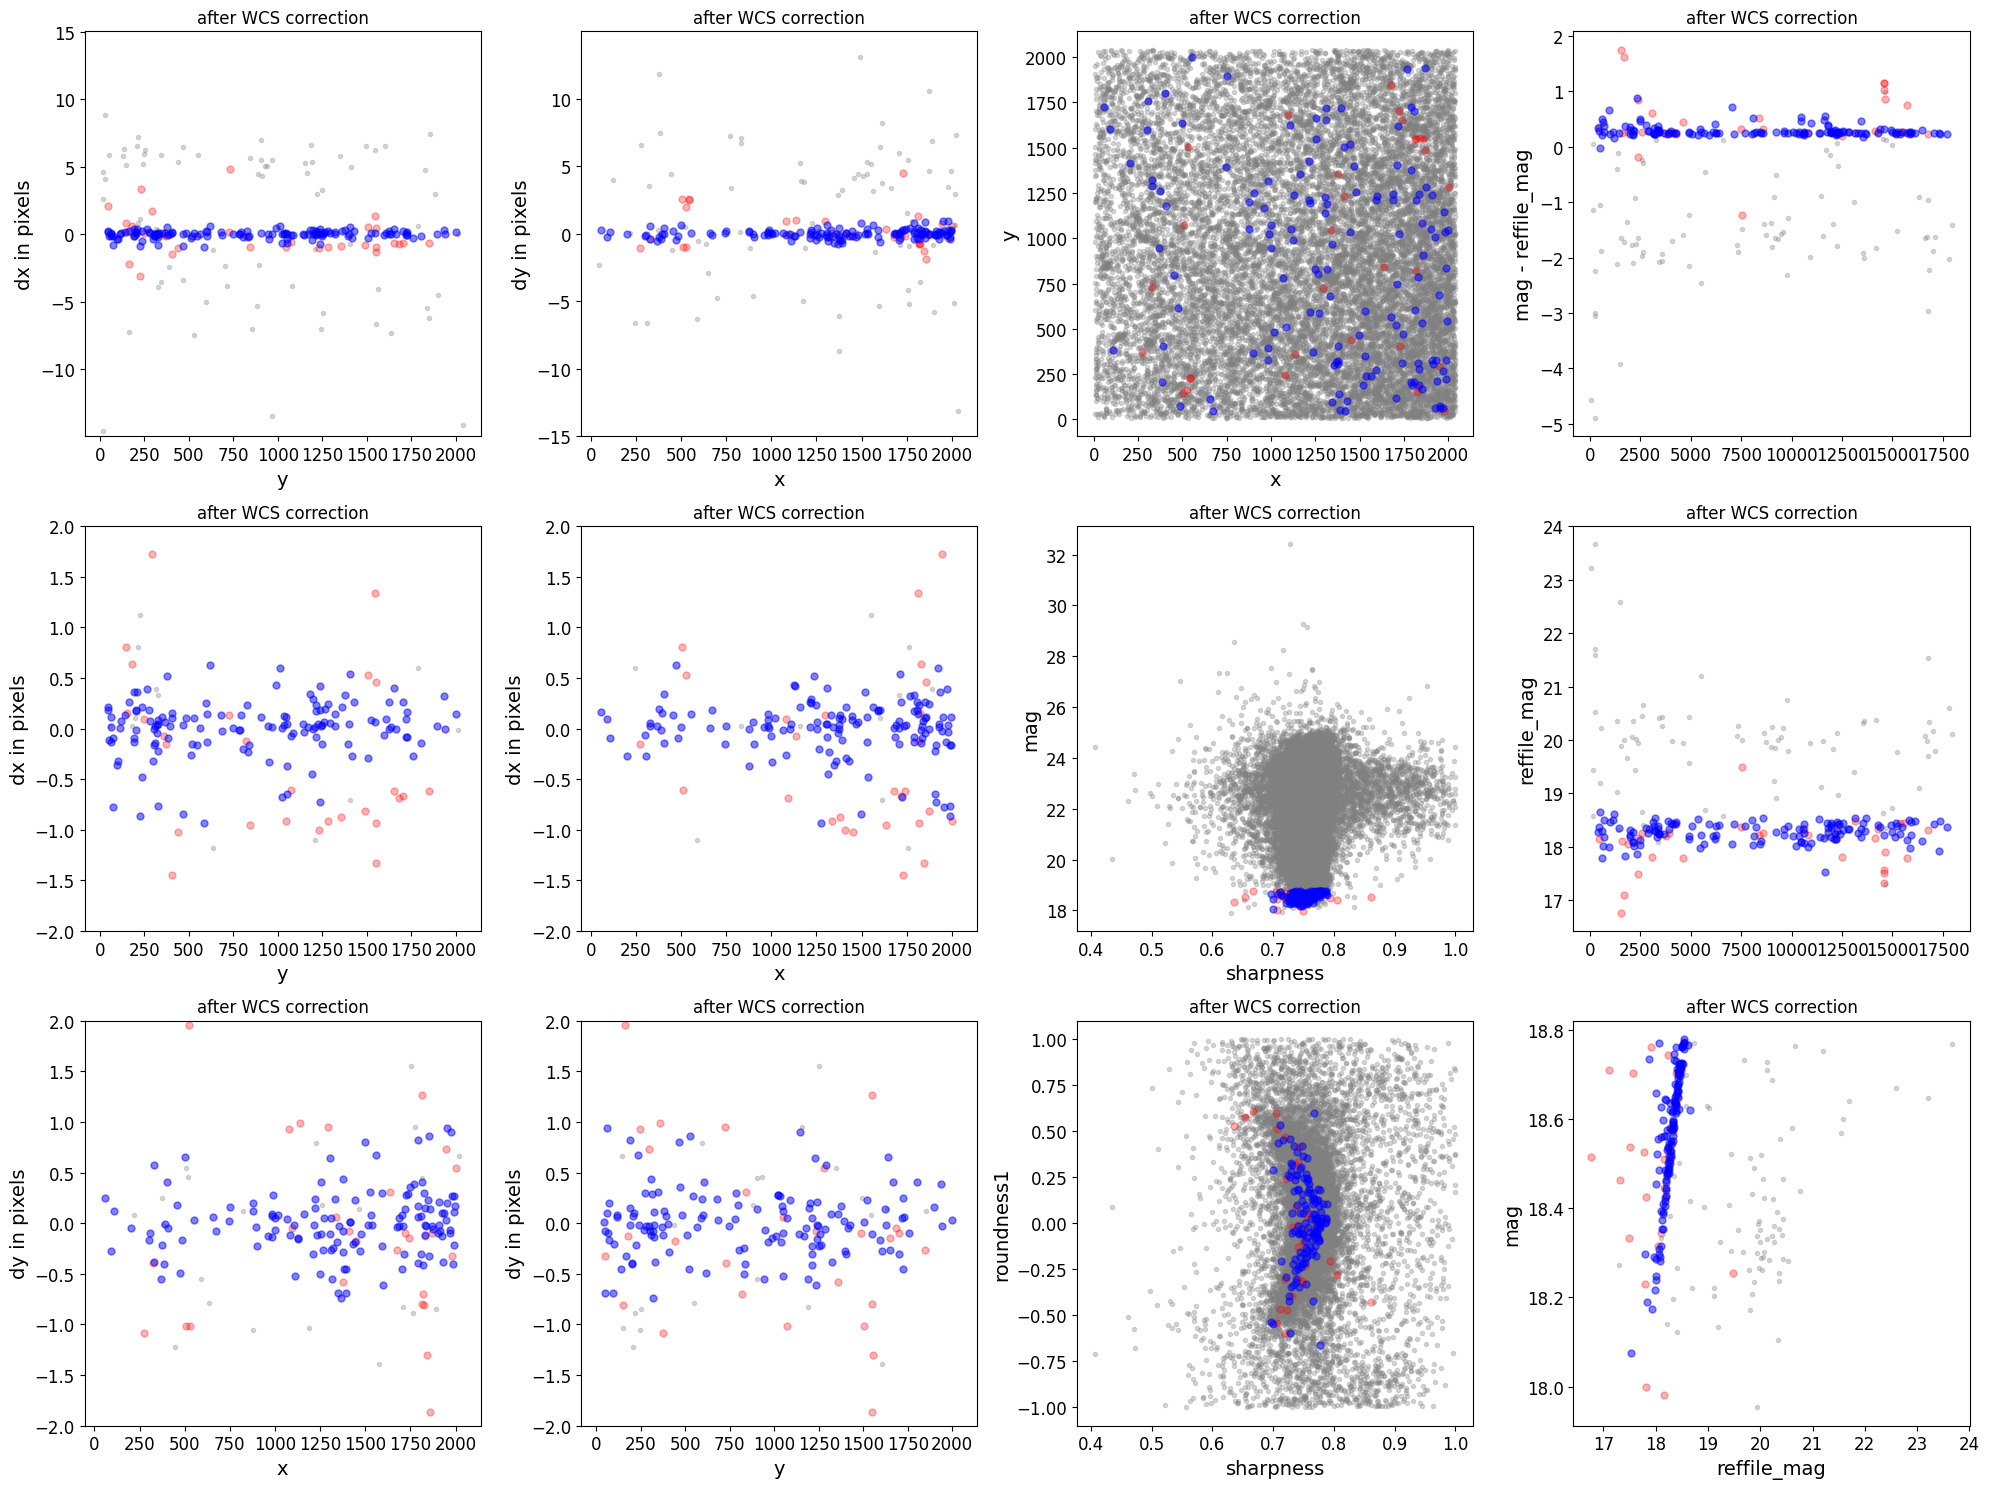

*** Note: close plots to continue!


0

In [66]:
wcs_align = st_wcs_align()


wcs_align.run_all(align_image,
          telescope='jwst',
          outsubdir='jwstred_temp_gaia',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.15,
          showplots=2,
          find_stars_threshold=5,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 5,
              dmag_max=0.1,
              Nbright=250,
              objmag_lim =(14,21),
              binsize_px = 0.8,
              use_dq = True)

## Align to Catalog

You can also align each image to the Gaia DR3 catalog, or you
could replace the catalog created in step one with your own
catalog of the field. 



In [4]:
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits')[0] #short wavelength
# align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00003_nrcblong_cal.fits')[0] #long wavelength
# align_image = glob.glob('jwstred_temp_gaia/jw01334-o001_t001_nircam_clear-f277w_i2d.fits')[0] #level3 file
# align_image = glob.glob('jwstred_temp_mosaic/jw02784002001_02101_00001_nrcb1_cal.fits')[0]

In [8]:
# to plot regions in ds9
try:
    align_df = pd.read_csv(align_image.replace('.fits', '.phot_psf.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')
except:
    align_df = pd.read_csv(align_image.replace('_cal.fits', '.phot.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')    

In [9]:
_df = pd.read_csv('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal_region.txt', sep = '\s+', header = None)
_df[0], _df[1] = _df[0]+1, _df[1]+1
np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), _df.values, fmt='%s')

telescope set to jwst

### Doing photometry on jwstred_temp_gaia/jw01334001001_02101_00003_nrcblong_cal.fits
True ./jwstred_temp_gaia/jw01334001001_02101_00003_nrcblong.phot.txt
photometry catalog filename: ./jwstred_temp_gaia/jw01334001001_02101_00003_nrcblong.phot.txt
photcat ./jwstred_temp_gaia/jw01334001001_02101_00003_nrcblong.phot.txt already exists, but recreating it since overwrite=True
Instrument: NIRCAM, aperture:NRCB5_FULL
Applying Pixel Area Map
Finding stars --- Detector: NRCBLONG, Filter: F277W
FWHM for the filter F277W: 1.444 px
Background and rms using MMMBackground and MADStdBackgroundRMS: 0.1084798276424408 0.13790897348042358


2024-10-08 11:48:54,422 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.



Number of sources found in the image: 31599
-------------------------------------



2024-10-08 11:48:54,633 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-10-08 11:48:54,649 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-10-08 11:48:54,650 - stpipe - INFO - Instrument: NIRCAM
2024-10-08 11:48:54,651 - stpipe - INFO - Detector: NRCBLONG
2024-10-08 11:48:54,651 - stpipe - INFO - Filter: F277W
2024-10-08 11:48:54,652 - stpipe - INFO - Pupil: CLEAR
2024-10-08 11:48:54,652 - stpipe - INFO - Subarray: FULL
2024-10-08 11:48:54,693 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


radii:[2.311]pixels radius_sky_in:3.0859999656677246 radius_sky_out:5.238999843597412  radius_for_mag:[2.311]
Performing aperture photometry for radius r = 2.311000108718872 px
Time Elapsed: 22.810681908999868
31351 objects left after removing entries with NaNs in mag or dmag column
dmag 0.2172
SNR_min cut: 31282 objects left after removing entries dmag>0.2172 (SNR<5)
31282 out of 31351 entries remain in photometry table
Saving ./jwstred_temp_gaia/jw01334001001_02101_00003_nrcblong.phot.txt
########### !!!!!!!!!!  INITIAL CUT on image photometry cat: starting with 31351 objects
dmag_max =0.1 CUT:
dmag 0.1
31162 left
SHARPNESS =(0.3, 0.95) CUT:
sharpness 0.95
31128 left
roundness1=(-0.7, 0.7) CUT:
roundness1 0.7
28949 left
objmag_lim=(15, 21) CUT:
mag 21
3478 left
3478 of image photometry objects pass initial cuts #1, 27873 cut
Getting Gaia and matching it: ra=259.31261742875427 dec=43.13940808228326 radius=0.03849224965992772 deg
RA/Dec columns in reference catalog:  auto auto


2024-10-08 11:49:37,187 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 8384
### NO propoer motion correction!!!
Number of stars after removing nan's: 8384
########### !!!!!!!!!!  INITIAL CUT on reference catalog: starting with 8384 objects
8384 of image photometry objects pass initial cuts #1, 0 cut
Matching reference catalog Gaia
Using 3478 image objects that are in x_idl=[-64.85,64.17] and y_idl=[-64.66,63.89] range
x 2008
y 2008
Keeping 2608 out of 8384 catalog objects within x=40.0-2008 and y=40.0-2008
Keeping 2608  after removing NaNs from ra/dec
!! Matching 3478 image objects to 2608 refcat objects!
########### !!!!!!!!!!  INITIAL CUT on matched cat: starting with 3478 objects
d2d =0.5 CUT using gaia_d2d:
gaia_d2d 0.5
484 left
484 of image photometry objects pass initial cuts #1, 2994 cut
dx median: 0.16245189855757758
dy median: 2.8765293163112347
*** Note: close plot to continue!


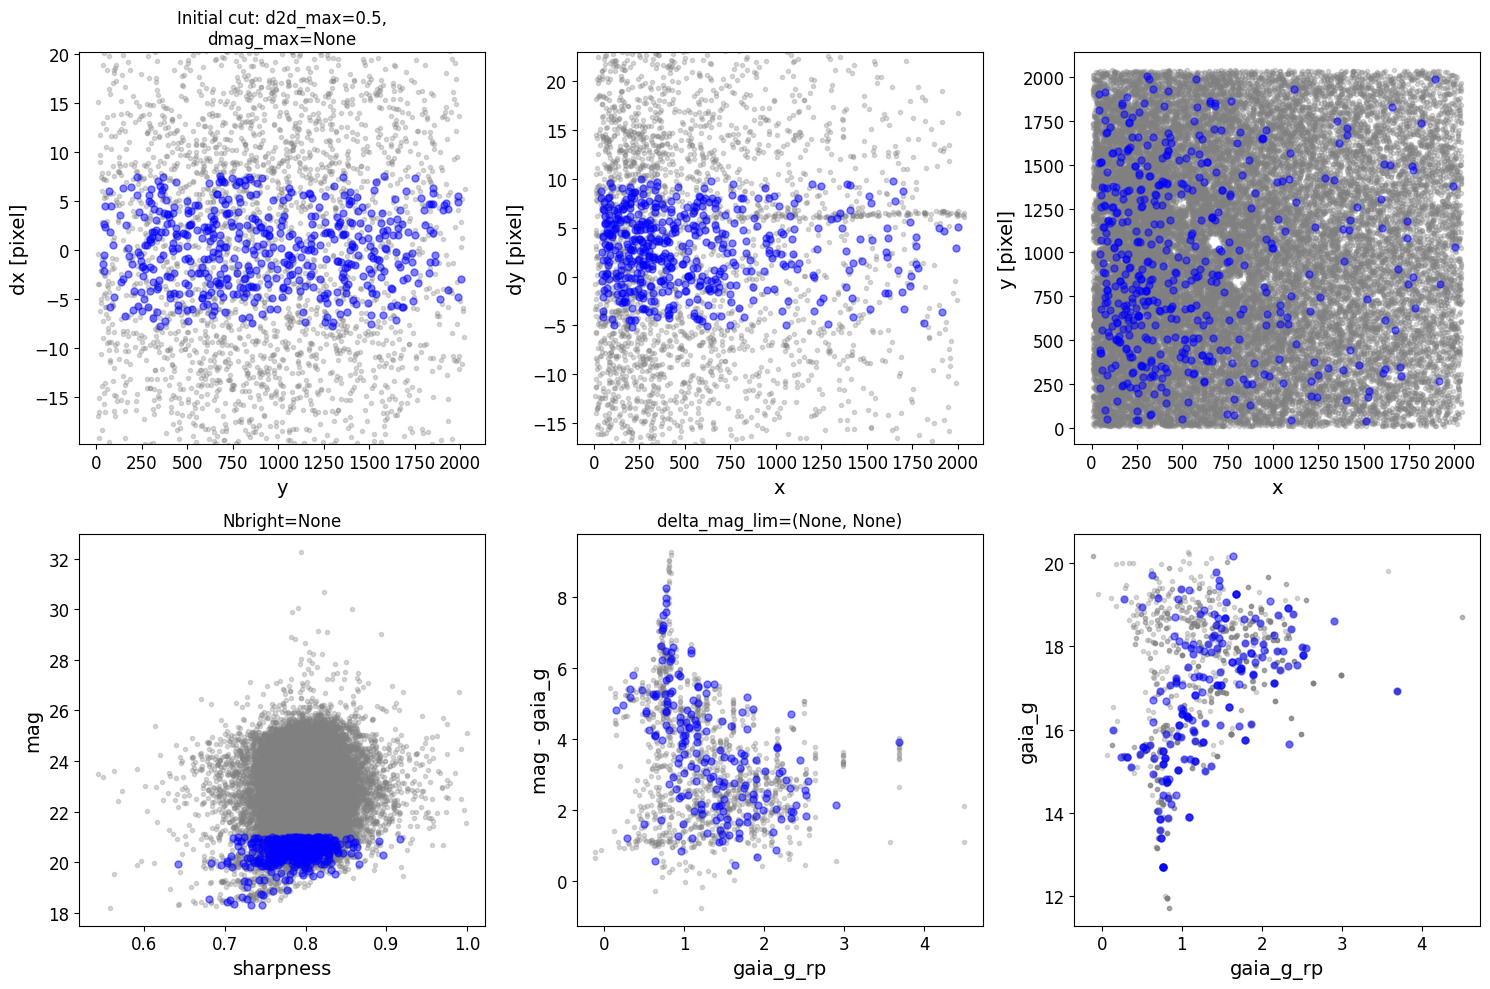

### Doing histogram cut for dx, slope_min:-0.009766 slope_max:0.009766 slope_stepsize:0.000098
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dx versus y
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
   slope  intercept  maxval  index  d_bestguess  fwhm  multimax
0.000195       -0.2    52.0     10     1.728235  12.0     False
BINWIDTH  1.5530335723457191
Setting rough_cut_px=30.0. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 2.5282353874641137

rough_cut_px=0.8 pixels removes 413 from 484 entries
Keeping 71 out of 71, skippin 0 because of null values in columns d_rot_tmp
median: 1.721801
75.000000 percentile cut: max residual for cut: 0.580184
__tmp_residuals 0.5801843850435878
median: 1.703072
i:00 mean:1.703072(0.038553) stdev:0.278011(0.027003) X2norm

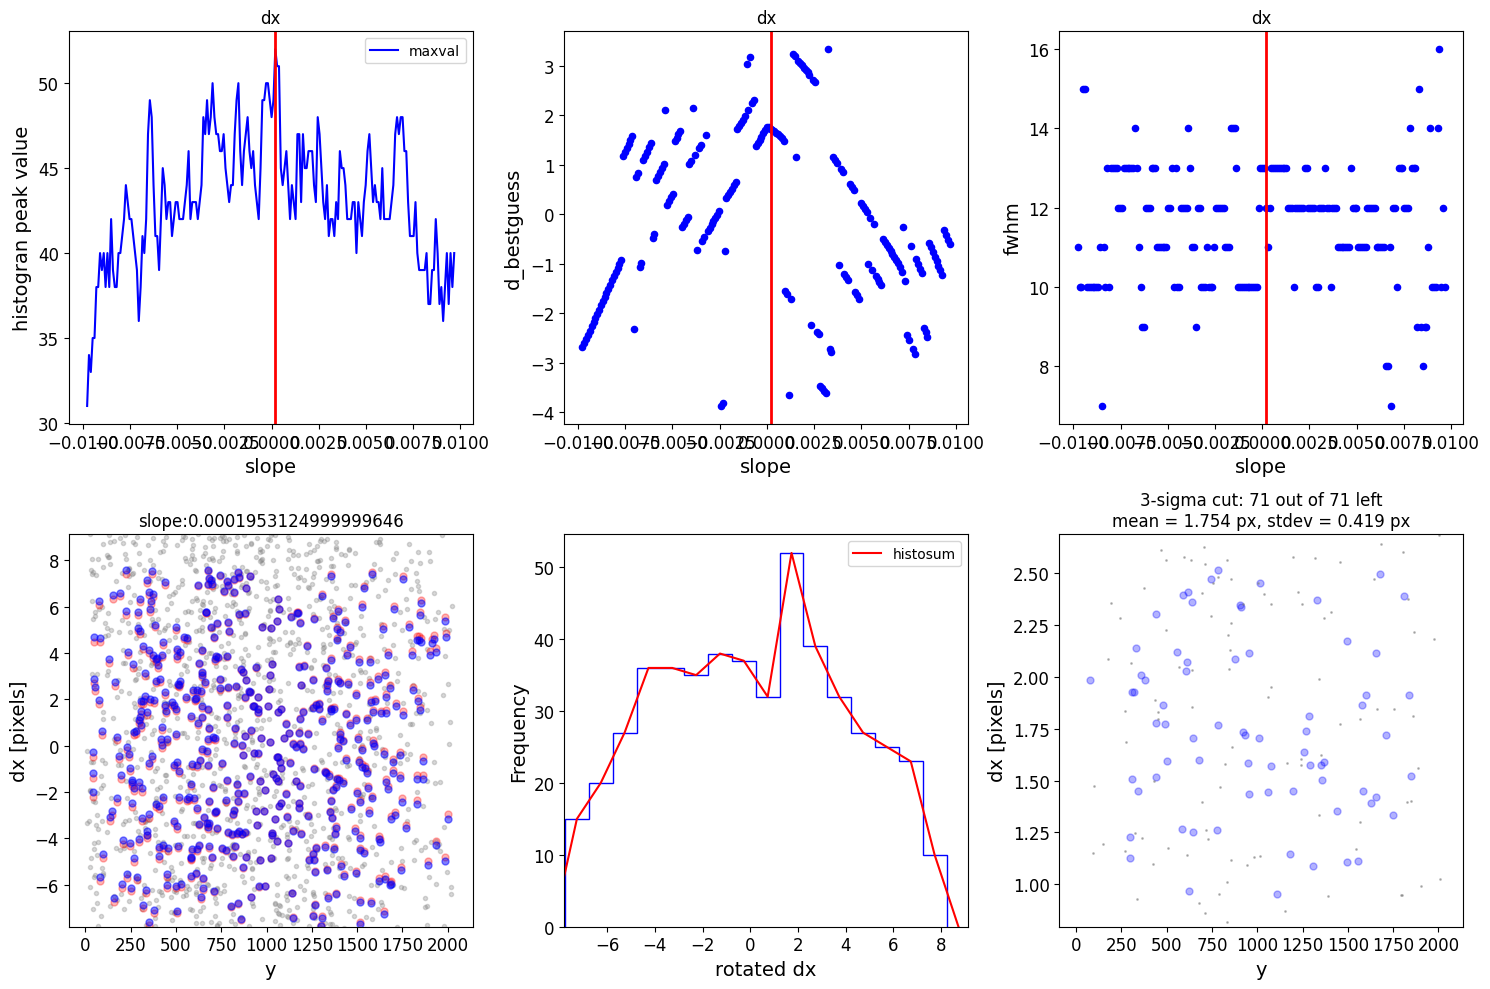

### Doing histogram cut for dy, slope_min:-0.009766 slope_max:0.009766 slope_stepsize:0.000098
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dy versus x
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
   slope  intercept  maxval  index  d_bestguess  fwhm  multimax
0.004102       -4.2    10.0      8     1.351109   2.0     False
BINWIDTH  3.435096433312725
Setting rough_cut_px=5.0. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 2.15110853294098

rough_cut_px=0.8 pixels removes 59 from 71 entries
Keeping 12 out of 12, skippin 0 because of null values in columns d_rot_tmp
median: 1.263872
75.000000 percentile cut: max residual for cut: 0.371043
__tmp_residuals 0.3710428072069877
median: 1.200238
i:00 mean:1.200238(0.086462) stdev:0.244551(0.057641) X2norm:0.94 

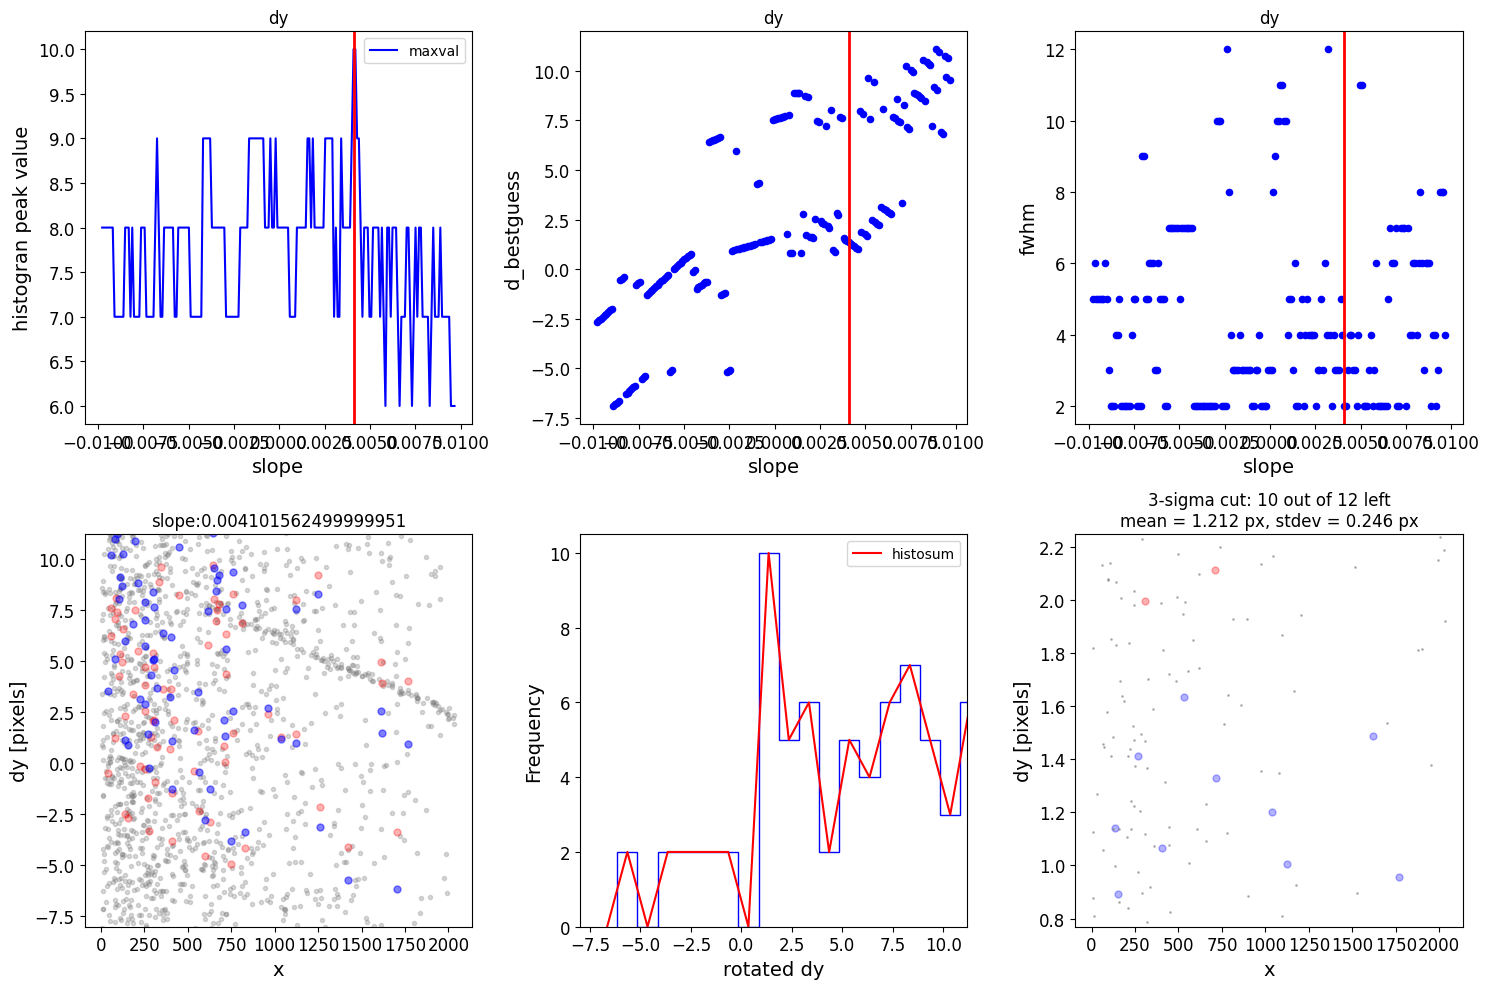

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

dx median of best matched objects of 1st iteration: 1.832677997292933 dy median of best matched objects of 1st iteration: -0.1589617275355124
Matching reference catalog Gaia
Using 3478 image objects that are in x_idl=[-64.85,64.17] and y_idl=[-64.66,63.89] range
x 2008
y 2008
Keeping 2608 out of 8384 catalog objects within x=40.0-2008 and y=40.0-2008
Keeping 2608  after removing NaNs from ra/dec
!! Matching 3478 image objects to 2608 refcat objects!
########### !!!!!!!!!!  INITIAL CUT on matched cat: starting with 3478 objects
d2d =0.5 CUT using gaia_d2d:
gaia_d2d 0.5
499 left
499 of image photometry objects pass initial cuts #1, 2979 cut
### Doing histogram cut for dx, slope_min:-0.009766 slope_max:0.009766 slope_stepsize:0.000098
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dx versus y
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
   

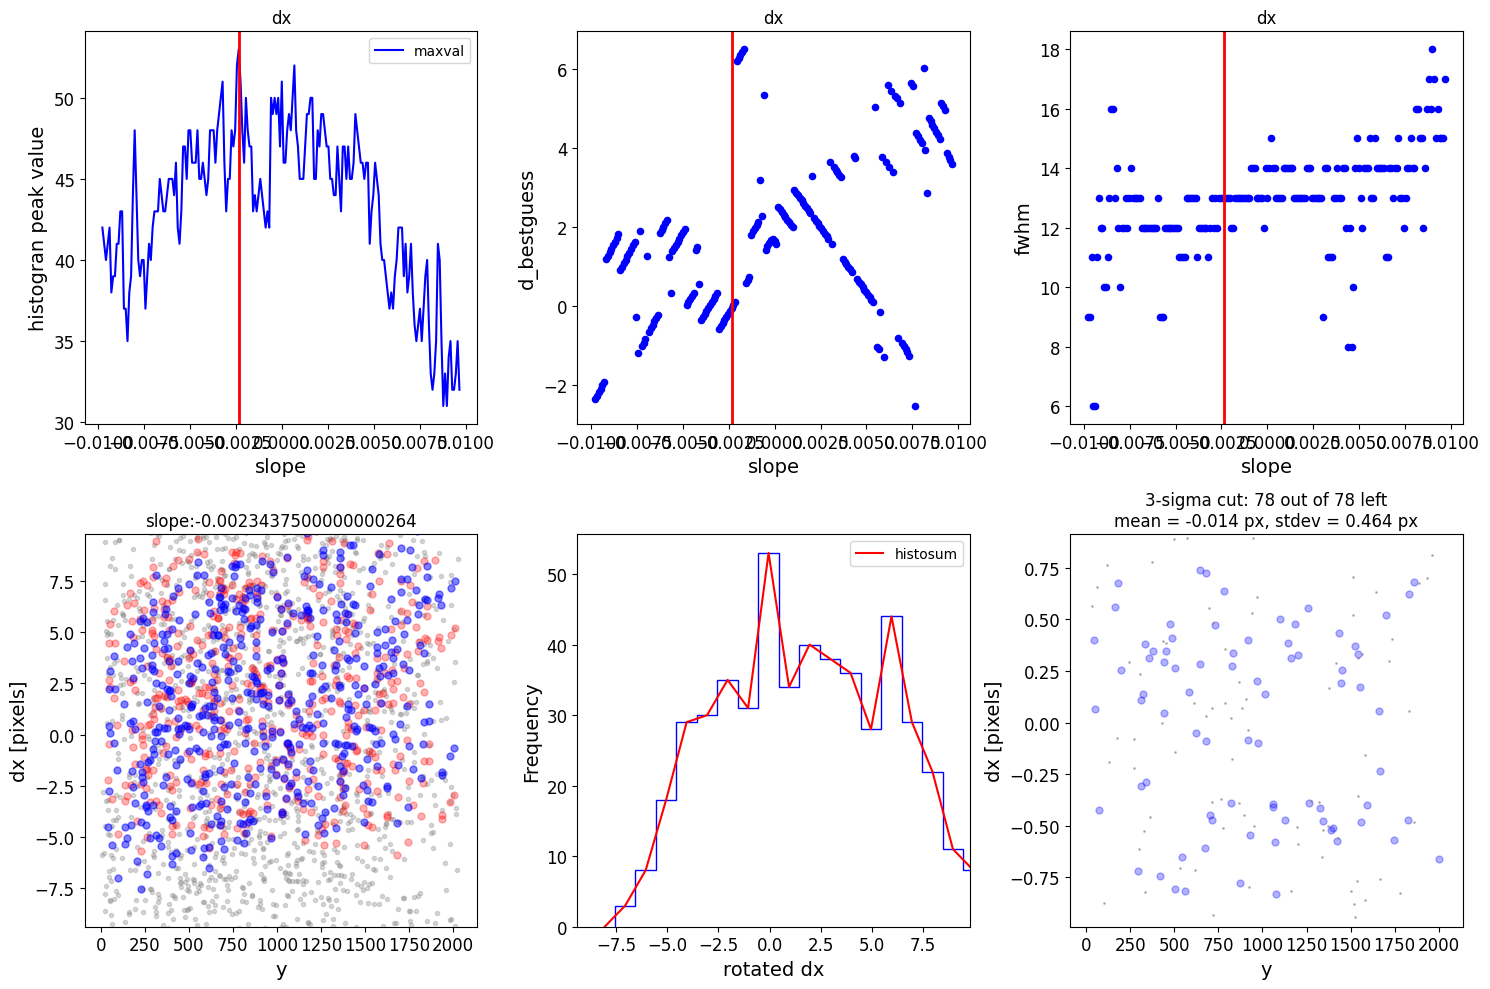

### Doing histogram cut for dy, slope_min:-0.009766 slope_max:0.009766 slope_stepsize:0.000098
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dy versus x
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.002344        2.4    12.0     10     0.000228   3.0     False
BINWIDTH  3.6801705766965993
Setting rough_cut_px=7.5. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 0.8002279180878926

rough_cut_px=0.8 pixels removes 64 from 78 entries
Keeping 14 out of 14, skippin 0 because of null values in columns d_rot_tmp
median: 0.162468
75.000000 percentile cut: max residual for cut: 0.338333
__tmp_residuals 0.3383331349505235
median: 0.186039
i:00 mean:0.186039(0.060694) stdev:0.182082(0.040715) X2norm:

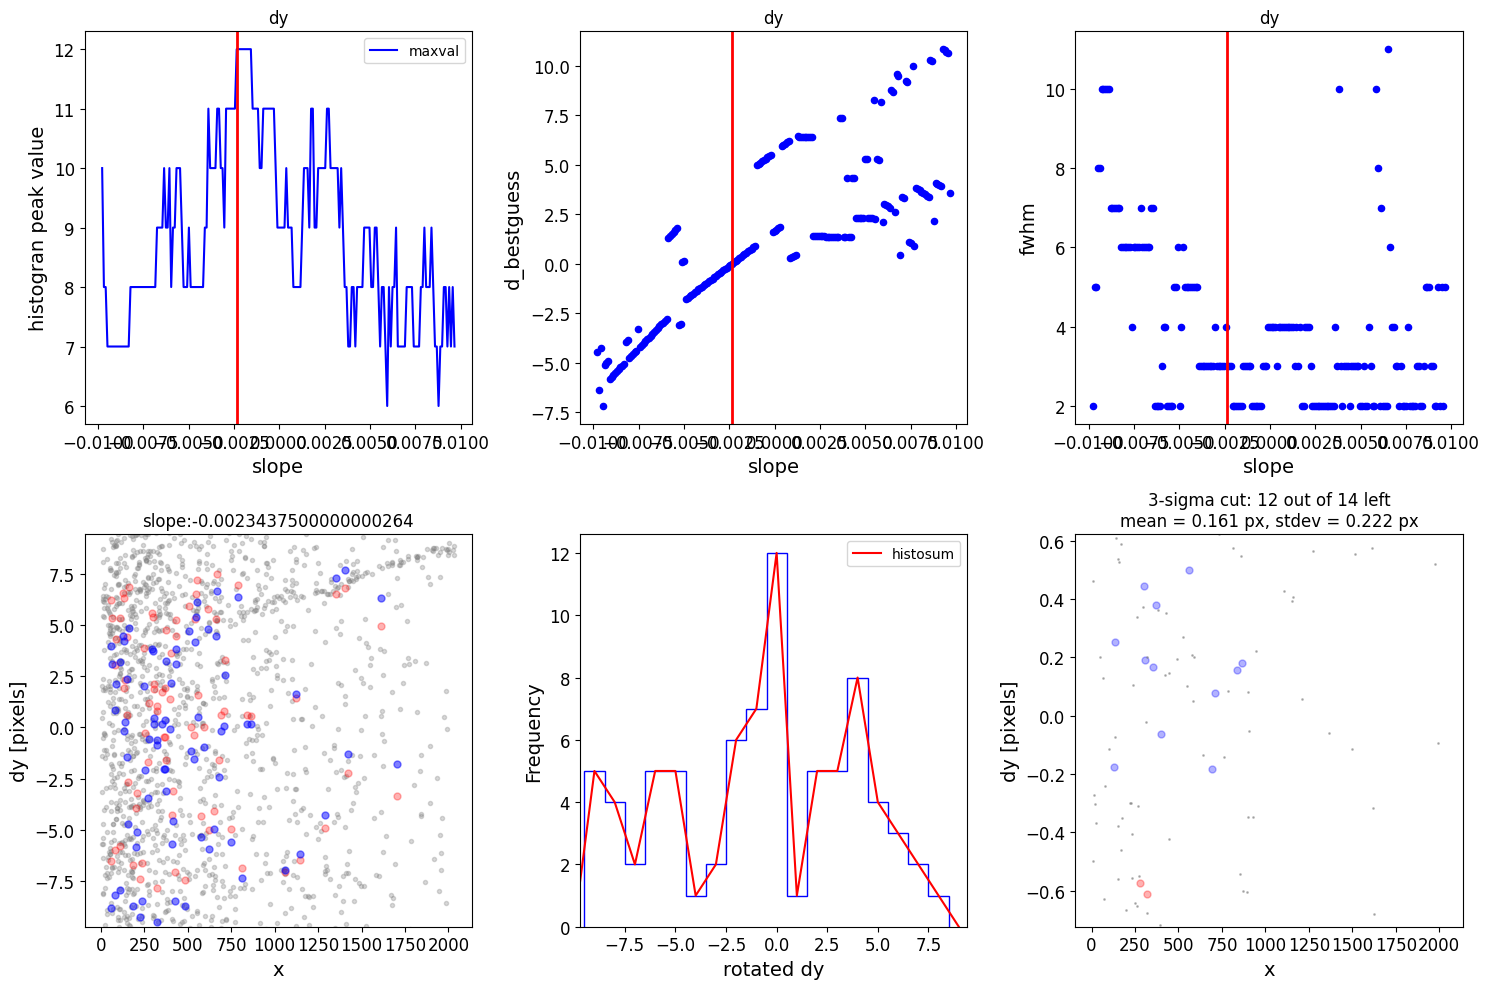

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-10-08 11:49:49,742 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.


Setting output directory for jw01334001001_02101_00003_nrcblong_jhat.fits file to ./jwstred_temp_gaia
12 matches are passed to tweakreg rshift fitting
Fitting tweakreg fitgeometry=rshift to xy=x,y to ra,dec=gaia_ra,gaia_dec


2024-10-08 11:49:50,282 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01334001001_02101_00003_nrcblong_cal.fits>],).
2024-10-08 11:49:50,287 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp_gaia/jw01334001001_02101_00003_nrcblong_jhat.fits
  output_dir: ./jwstred_temp_gaia
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_gaia: False
  gaia_catalog: GAIADR2
  min_gaia: 30
  save_gaia_catalog: False
  

replacing SIP ./jwstred_temp_gaia/jw01334001001_02101_00003_nrcblong_jhat.fits


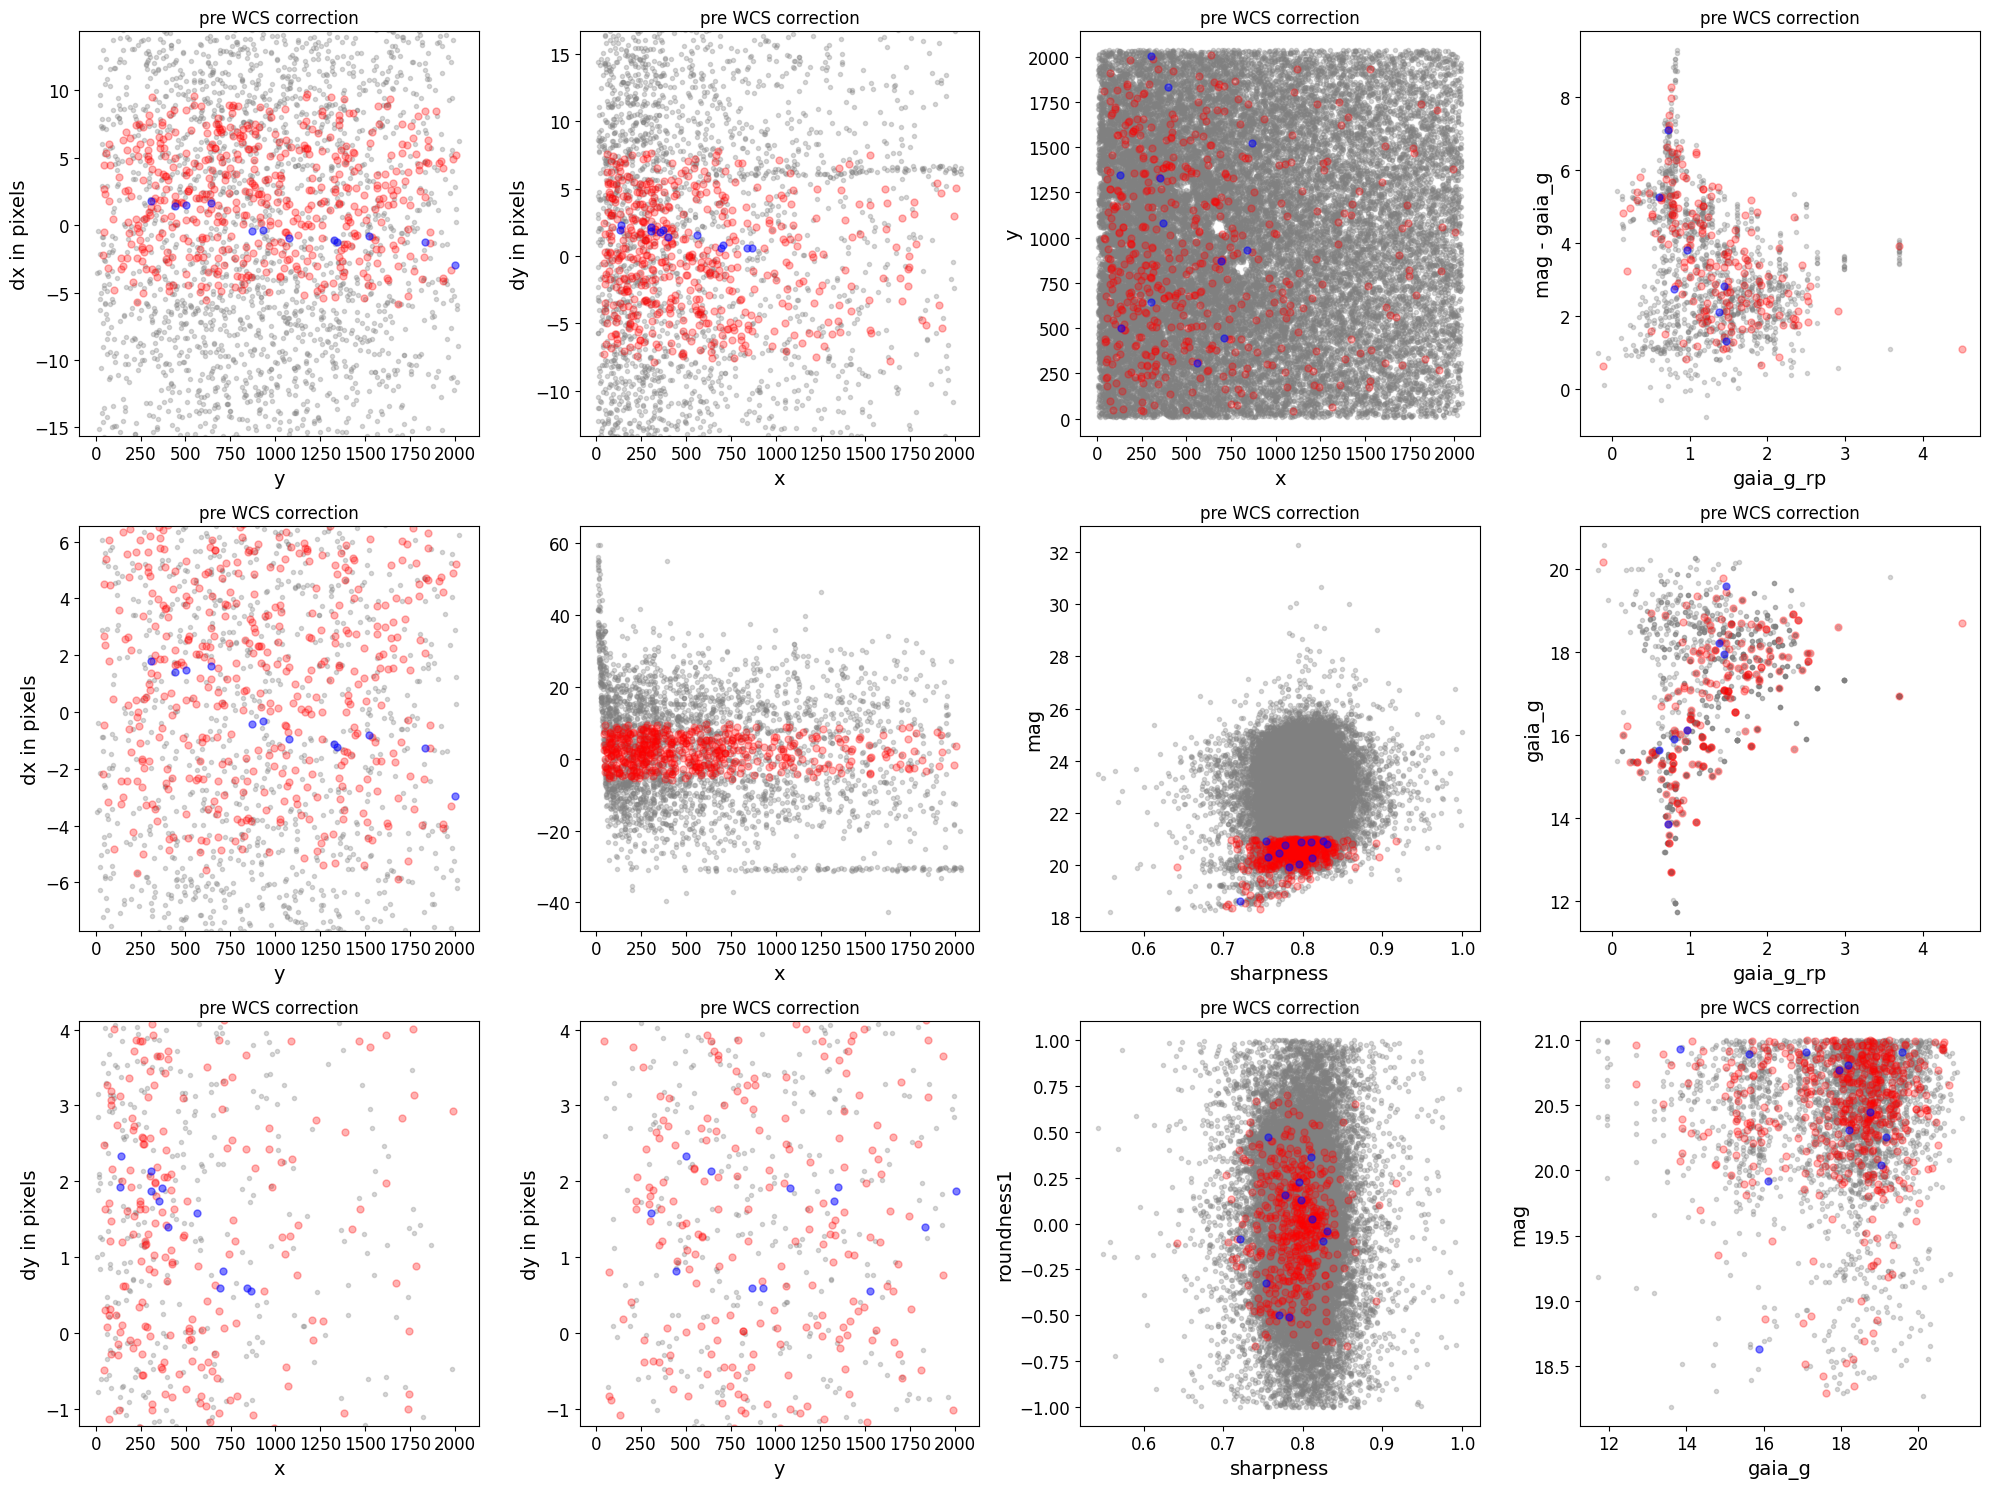

./jwstred_temp_gaia/jw01334001001_02101_00003_nrcblong_jhat.fits


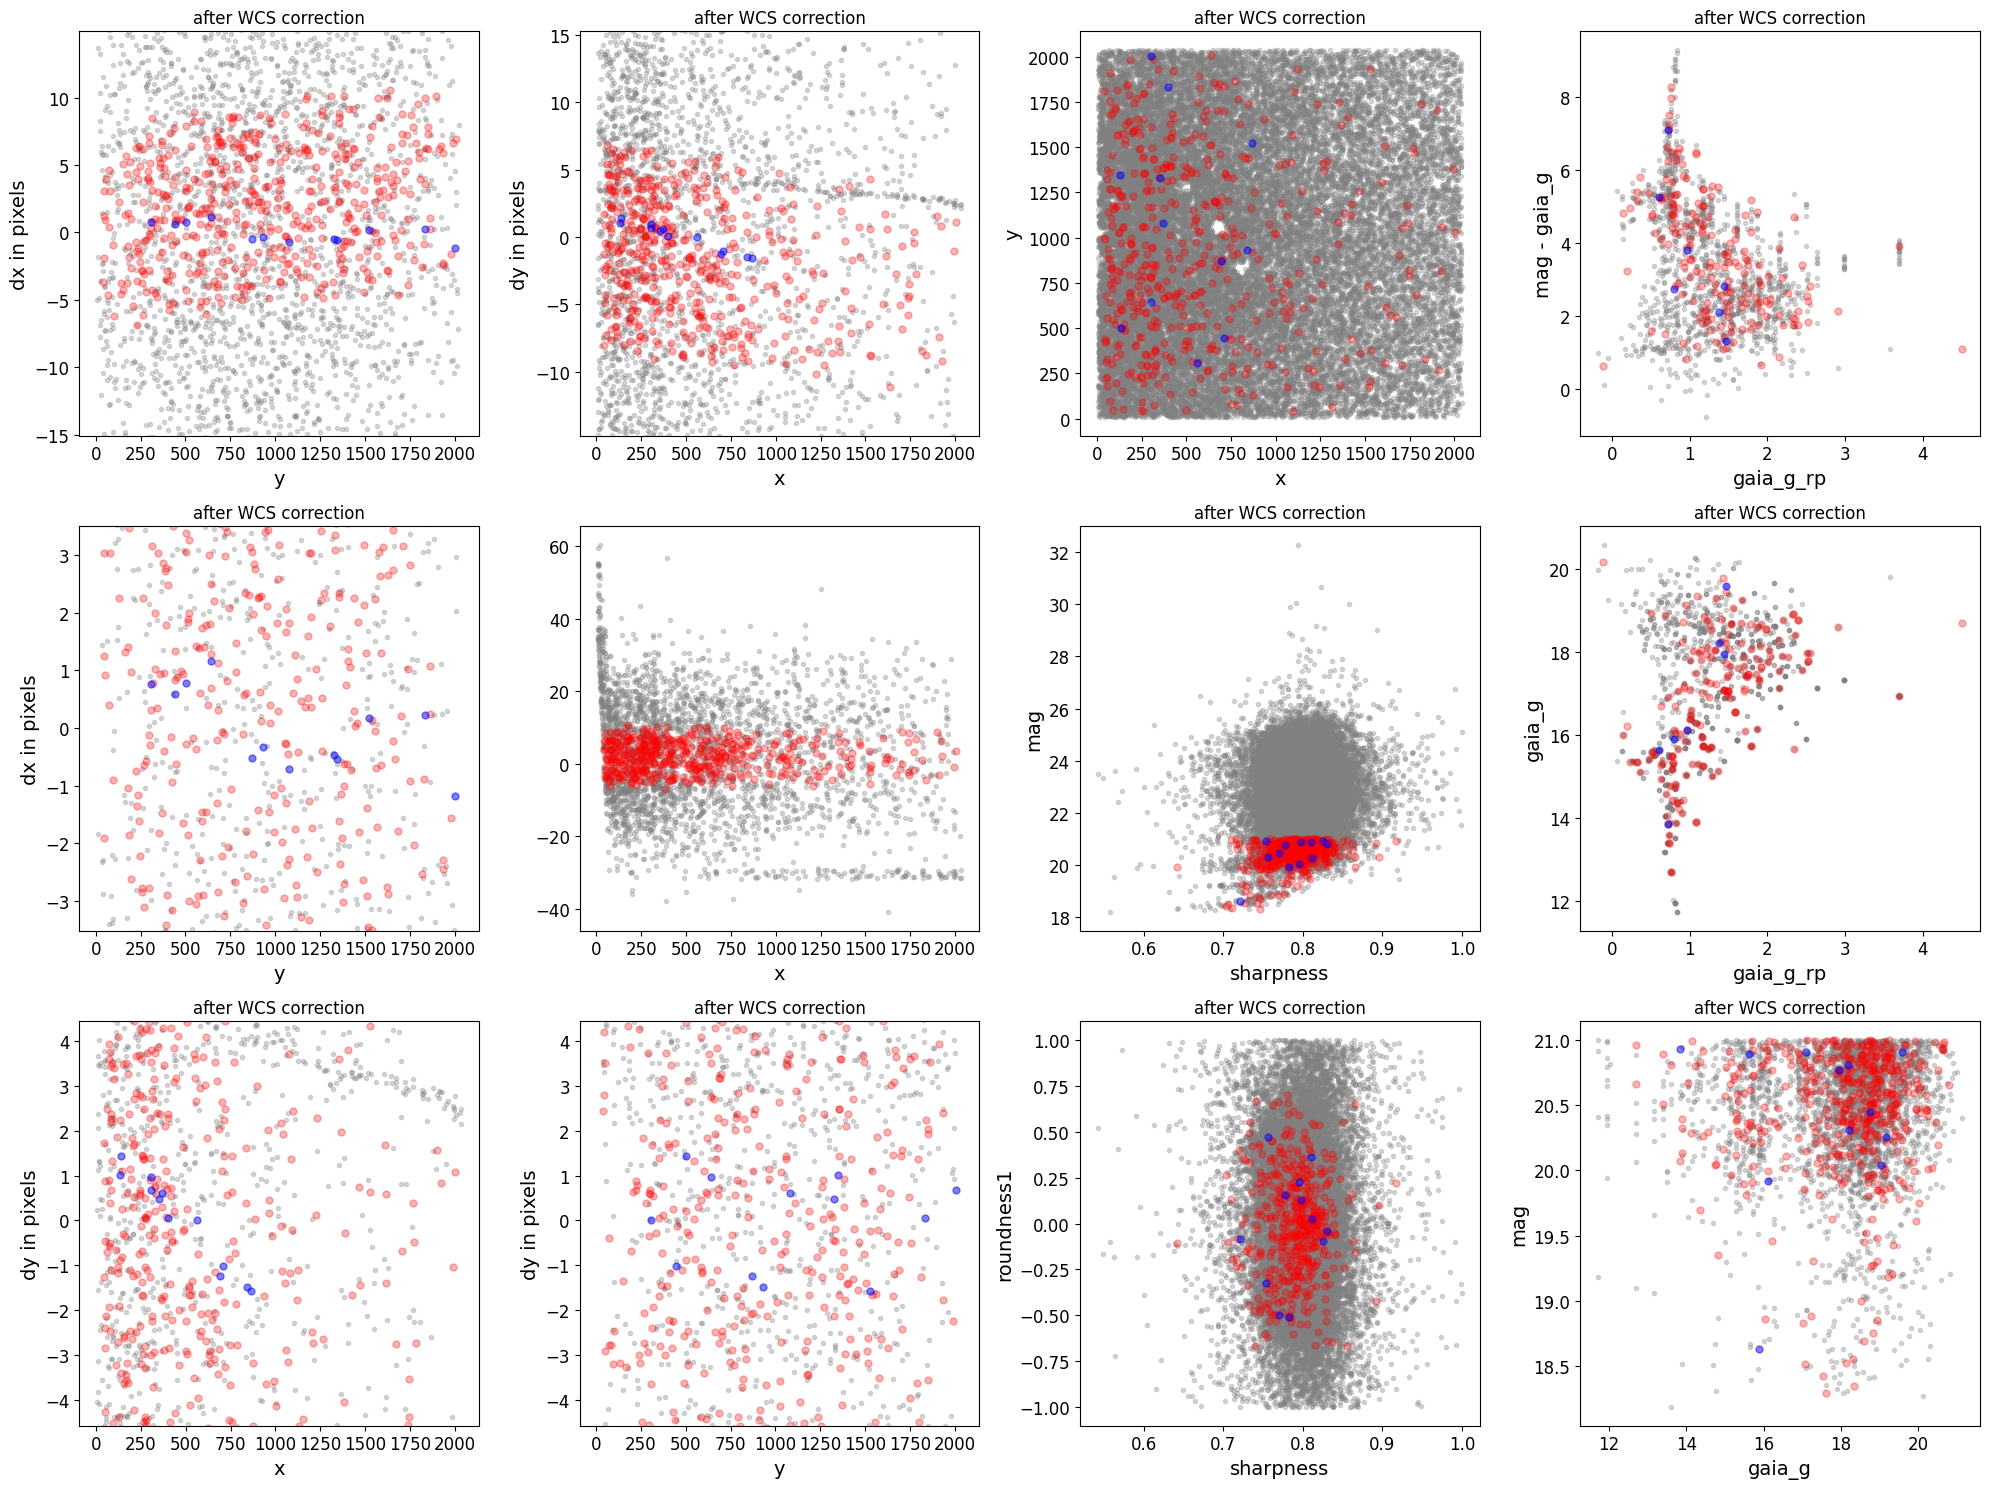

*** Note: close plots to continue!


0

In [11]:
wcs_align = st_wcs_align()
    
wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp_gaia',
          overwrite=True,
          d2d_max=.5, 
          find_stars_threshold = 3,
          showplots=2,
          refcatname='Gaia',
          refcat_pmflag = True,
          histocut_order='dxdy',
          verbose = True,
          iterate_with_xyshifts = True,
#           xshift = 7,
          yshift = 2.5,
              sharpness_lim=(0.3,0.95),
              roundness1_lim=(-0.7, 0.7),
#               Nbright = 1000,
              SNR_min= 5,
              dmag_max=.1,
              objmag_lim =(15,21),
              binsize_px = 1.0,
              saveplots = 0,
              slope_min = -20/2048)

#### Create ds9 region files

In [12]:
source_df = pd.read_csv('good_sources_initial.csv')
np.savetxt('good_locs.txt', source_df[['x', 'y']].values, fmt = '%s')
np.savetxt('gaia_locs.txt', source_df[['gaia_x', 'gaia_y']].values, fmt = '%s')
np.savetxt('gaiaradec.txt', source_df[['gaia_ra', 'gaia_dec']].values, fmt = '%s')
np.savetxt('jwstradec.txt', source_df[['ra', 'dec']].values, fmt = '%s')

In [13]:
source_df.columns

Index(['aper_sum_2.3px', 'annulus_median_2.3px', 'aper_bkg_2.3px',
       'aper_sum_bkgsub_2.3px', 'flux_err_2.3px', 'mag', 'dmag', 'x', 'y',
       'sharpness', 'roundness1', 'roundness2', 'ra', 'dec', 'x_idl', 'y_idl',
       'gaia_ra', 'gaia_dec', 'gaia_x', 'gaia_y', 'gaia_ID', 'gaia_g',
       'gaia_g_err', 'gaia_g_rp', 'gaia_SOURCE_ID', 'gaia_ra_error',
       'gaia_dec_error', 'gaia_rp', 'gaia_rp_err', 'gaia_g_rp_err', 'gaia_d2d',
       'dx', 'dy', 'delta_mag'],
      dtype='object')

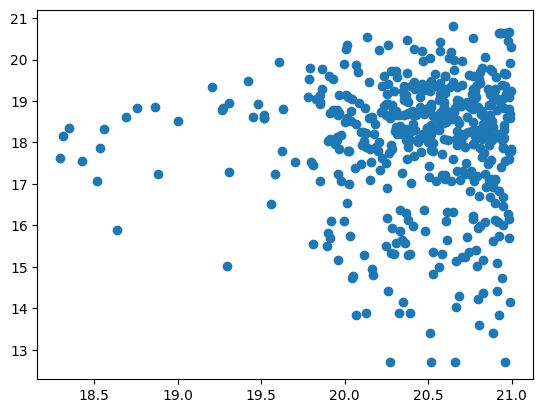

In [14]:
plt.scatter(source_df['mag'], source_df['gaia_g'])

In [ ]:
# to plot regions in ds9
try:
    align_df = pd.read_csv(align_image.replace('.fits', '.phot_psf.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')
except:
    align_df = pd.read_csv(align_image.replace('_cal.fits', '.phot.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')    

#### Gaia xmatch

In [14]:
from jwst.datamodels import ImageModel

In [15]:
im = fits.open(align_image)

hdr = im['SCI'].header
nx = hdr['NAXIS1']
ny = hdr['NAXIS2']

image_model = ImageModel(im)

ra0,dec0 = image_model.meta.wcs(nx/2.0-1,ny/2.0-1)
coord0 = SkyCoord(ra0,dec0,unit=(u.deg, u.deg), frame='icrs')
radius_deg = []
for x in [0,nx-1]:        
    for y in [0,ny-1]:     
        ra,dec = image_model.meta.wcs(x,y)
        radius_deg.append(coord0.separation(SkyCoord(ra,dec,unit=(u.deg, u.deg), frame='icrs')).deg)
radius_deg = np.amax(radius_deg)*1.1

In [16]:
dr = 'gaiadr3'

query ="SELECT * FROM {}.gaia_source WHERE CONTAINS(POINT('ICRS',\
        {}.gaia_source.ra,{}.gaia_source.dec),\
        CIRCLE('ICRS',{},{} ,{}))=1;".format(dr,dr,dr,ra0,dec0,radius_deg)

job5 = Gaia.launch_job_async(query)
tb_gaia = job5.get_results() 
print("Number of stars:",len(tb_gaia))

2024-09-27 15:56:54,654 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 1446


In [17]:
tb_gaia

<Table length=1446>
    solution_id             DESIGNATION          ... libname_gspphot
                                                 ...                
       int64                   object            ...      object    
------------------- ---------------------------- ... ---------------
1636148068921376768 Gaia DR3 1360405022423774592 ...                
1636148068921376768 Gaia DR3 1360405400378561920 ...                
1636148068921376768 Gaia DR3 1360405400378562048 ...                
1636148068921376768 Gaia DR3 1360405400380332544 ...                
1636148068921376768 Gaia DR3 1360405400380332800 ...                
1636148068921376768 Gaia DR3 1360405022421437824 ...                
1636148068921376768 Gaia DR3 1360405022423778048 ...                
1636148068921376768 Gaia DR3 1360405022423778944 ...                
1636148068921376768 Gaia DR3 1360405091143265920 ...                
                ...                          ... ...             ...
1636148068921376768 Gaia DR3 1360405675256795008 ...                
1636148068921376768 Gaia DR3 1360405675256821120 ...                
1636148068921376768 Gaia DR3 1360405675256821248 ...                
1636148068921376768 Gaia DR3 1360405675260824832 ...                
1636148068921376768 Gaia DR3 1360405675260823808 ...                
1636148068921376768 Gaia DR3 1360405675260824320 ...                
1636148068921376768 Gaia DR3 1360405675260829440 ...                
1636148068921376768 Gaia DR3 1360405675262442496 ...                
1636148068921376768 Gaia DR3 1360405675262448256 ...

In [26]:
np.array(tb_gaia[['ra', 'dec']])
np.savetxt('all_gaia_locs.txt', np.array(tb_gaia[['ra', 'dec']]), fmt = '%s')

In [8]:
jhat_df = pd.read_csv(glob.glob(align_image.replace('.fits', '.phot.txt'))[0], sep = '\s+') #useful
# jhat_df[['x', 'y']].to_csv('region.csv', header = None, index = False)

In [9]:
jh_ra, jh_dec = jhat_df['ra'].to_numpy()*u.degree, jhat_df['dec'].to_numpy()*u.degree
jh_skycoord = SkyCoord(ra = jh_ra, dec = jh_dec)
ga_ra, ga_dec = np.array(tb_gaia['ra'])*u.degree, np.array(tb_gaia['dec'])*u.degree
ga_skycoord = SkyCoord(ra = ga_ra, dec = ga_dec)

In [10]:
dist_matched_df = xmatch_common(jh_skycoord, ga_skycoord, dist_limit=0.5)

Text(0.5, 1.0, 'jwst/gaia xmatch')

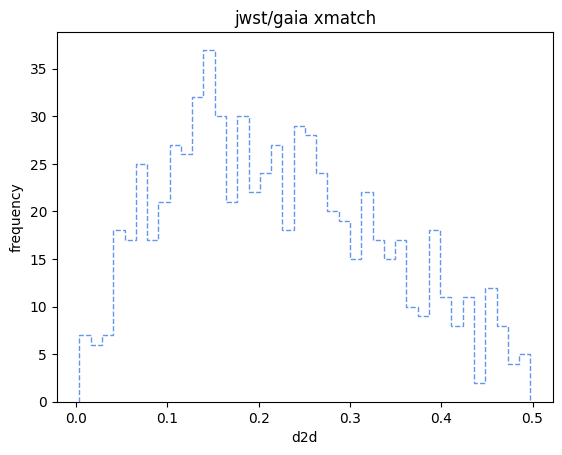

In [11]:
_ = plt.hist(dist_matched_df['d2d'], bins = 40, histtype = 'step', 
             linestyle = '--', color = 'cornflowerblue')
plt.xlabel('d2d')
plt.ylabel('frequency')
plt.title('jwst/gaia xmatch')

#### Breakup star mask

In [95]:
jwst_im = fits.open(glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits')[0])

In [96]:
jwst_im.info()

Filename: jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     346   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [26596B]   


In [97]:
dq_mask = jwst_im['DQ'].data

In [98]:
flag_sat = np.array(dq_mask != 1) & np.array(dq_mask != 2) & np.array(dq_mask != 3)

In [99]:
np.shape(flag_sat), np.shape(dq_mask)

((2048, 2048), (2048, 2048))

In [100]:
flag_sat.sum()

4185605

In [101]:
dq_mask[flag_sat] = 10
dq_mask[~flag_sat] = 1

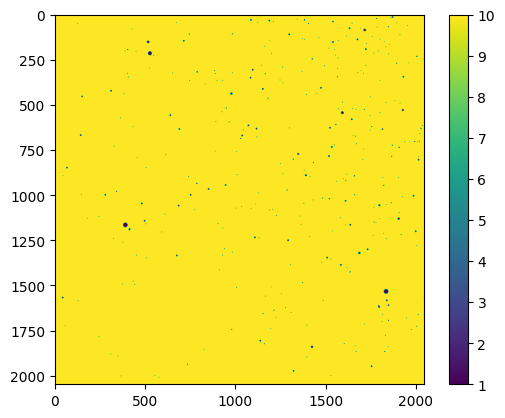

In [102]:
plt.imshow(dq_mask)
plt.colorbar()

In [103]:
np.unique(dq_mask)

array([ 1, 10], dtype=uint32)

In [104]:
def expand_mask(mask):
    # Create a binary mask where pixels with flag 1 are set to True
    binary_mask = (mask == 1)
    
    # Define a 10x10 structuring element
    structuring_element = np.ones((40, 40), dtype=bool)
    
    # Perform binary dilation
    expanded_mask = binary_dilation(binary_mask, structure=structuring_element)
    
    # Convert the expanded binary mask back to the original mask format
    mask_exp = np.where(expanded_mask, 1, mask)
    
    return mask_exp

In [105]:
expmask = expand_mask(dq_mask)
expmask[expmask == 1] = False
expmask[expmask == 10] = True

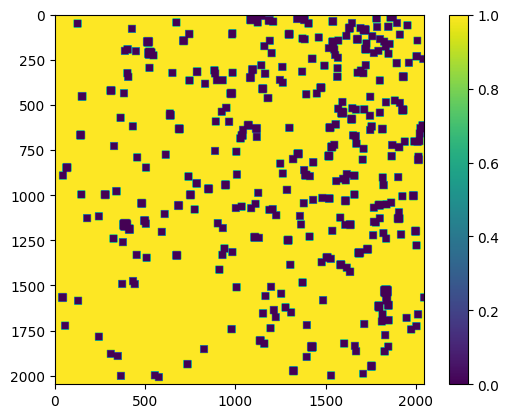

In [106]:
plt.imshow(expmask)
plt.colorbar()

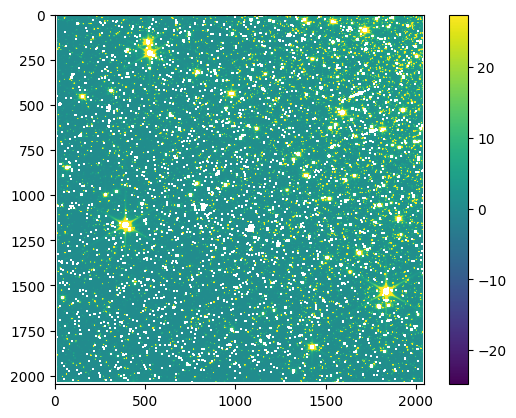

In [107]:
plt.imshow(jwst_im['SCI'].data, vmin = np.nanmedian(jwst_im['SCI'].data) - 1*np.nanstd(jwst_im['SCI'].data),
                                vmax = np.nanmedian(jwst_im['SCI'].data) + 1*np.nanstd(jwst_im['SCI'].data))
plt.colorbar()

In [108]:
masked_im = np.where(expmask, jwst_im['SCI'].data, np.nan)

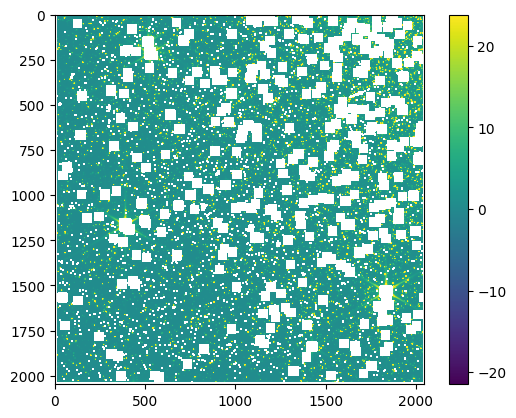

In [109]:
plt.imshow(masked_im, vmin = np.nanmedian(masked_im) - 1*np.nanstd(masked_im),
                      vmax = np.nanmedian(masked_im) + 1*np.nanstd(masked_im))
plt.colorbar()

In [110]:
masked_im

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [111]:
jwst_im['SCI'].data = masked_im

In [112]:
jwst_im.writeto('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal_masked.fits', overwrite = True)